## Aca vamos a calcular el fdisk en funcion del radio

Md =  5.91937e+09 Rd =  3.12199


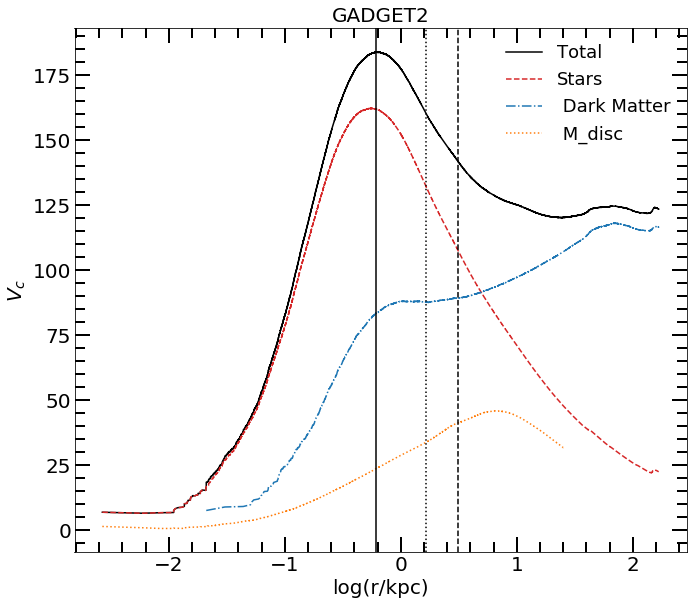

Md =  7.18203e+09 Rd =  3.36127


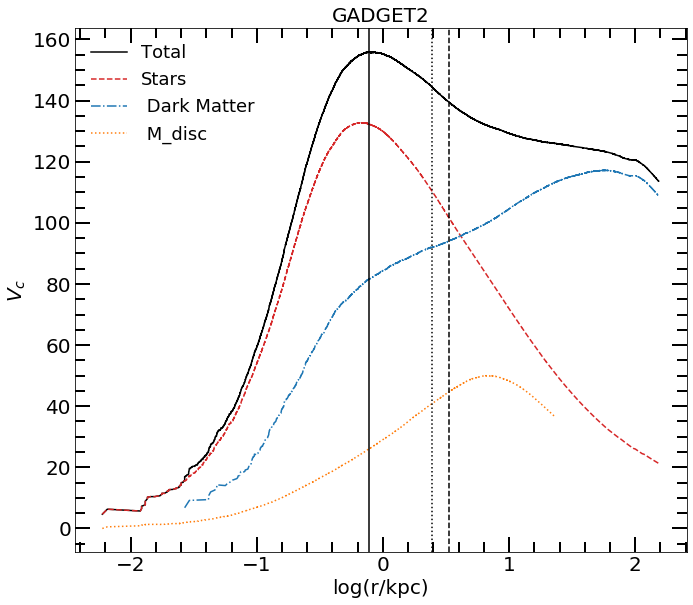

Md =  5.37427e+09 Rd =  3.56841


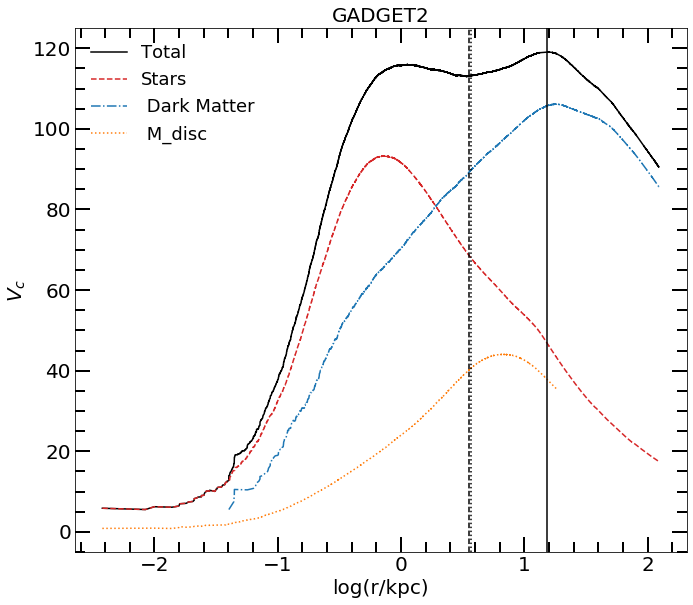

In [51]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import circular_velocity as vcirc
import density

colors = ('r','b','g')
vector = ('00','01','03')
vector2 = ('M31', 'MW', 'M33')

h =0.732
G = 4.299e-6
a0 =1
H0 = h*100
omega_lambda = 0.716
omega_matter = 0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

# path = '/home/omarioni/'
path = '/home/ornela/SimCLUES/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
aexp = aexp[::-1]

#     path = '/mnt/is2/alejandro/ornella/'    
snap = h5py.File(path + 'outputs_1/snap_496.h5py', 'r')

for i in range(0,3):
# i=0
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'][()]
    r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'][()]

    pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'][()]
    mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'][()]
    vel  = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Velocities'][()]

    pgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Coordinates'][()]
    mgas = snap['subhalo_0'+ str('%s' %vector[i]) + '/Gas/Masses'][()]

    pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'][()]
    mdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Masses'][()]

    z = a0/aexp[0] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    #     time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[0]/h
    ystr = (pstr[:,1]-cm[1])*aexp[0]/h
    zstr = (pstr[:,2]-cm[2])*aexp[0]/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[0]/h
    ygas = (pgas[:,1]-cm[1])*aexp[0]/h
    zgas = (pgas[:,2]-cm[2])*aexp[0]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[0]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[0]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[0]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] *np.sqrt(aexp[0]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[0]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[0]) + Ht *zstr/1000.
    #----------------------masas----------------------------
    mstr = mstr*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h

    r200 = r200*aexp[0]/h

    #     print 'r200 =', r200
    rgal=0.15*r200

    limit    = np.where(rstr<rgal)
    r_sort   = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    limit_str   = np.where(rstr<r200)
    rstr_sort   = np.sort(rstr[limit_str])
    rstr_indice = np.argsort(rstr[limit_str])

    limit_gas   = np.where(rgas<r200)
    rgas_sort   = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk   = np.where(rdrk<r200)
    rdrk_sort   = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])


    Mgal_str = np.cumsum((mstr[limit])[r_indice])

    Mc_str = np.cumsum((mstr[limit_str])[rstr_indice])

    Mc_gas = np.cumsum((mgas[limit_gas])[rgas_indice])

    Mc_drk = np.cumsum((mdrk[limit_drk])[rdrk_indice])

    #------------------ calculamos r90, r50------------------------------------------
    M_gal = Mgal_str[-1]

    razon       = Mgal_str/M_gal
    cincuenta,    = np.where(razon < 0.50)

    r50 = r_sort[cincuenta][-1]
    #--------------------------------------------------------------       
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    mtot_sort = mtot[limit_tot][rtot_indice]
    Mc_tot = np.cumsum(mtot_sort)

    #print 'Mvir=', Mc_tot[-1], 'r50=', r50[-1]
    #--------------------------------------------------------------

    Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
    Vstr = np.sqrt((G*Mc_str)/rstr_sort)
    Vgas = np.sqrt((G*Mc_gas)/rgas_sort)
    Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)

    rmax = rtot_sort[np.argmax(Vtot)]
#----------------------------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)

    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    #-------------------------------------------------------------------------------------
    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[0])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit, = np.where(rn < rgal )

    R = np.sqrt(xn[limit]**2+yn[limit]**2)
    Rsort = np.sort(R)

    nbin = 25
    den, Rbin = density.surf_density(R,mstr[limit],nbin)


    cut, = np.where(Rbin > 3*aexp[0])
    pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

    Rd = -1./pol[0]

    Sigma_0 = np.exp(pol[1])

    Md = 2*np.pi * Sigma_0 * Rd**2 * (1 - np.exp(-Rsort/Rd) * (1 + Rsort/Rd))
    
    rsort =np.sort(rn[limit])
    Vd = np.sqrt(G*Md/rsort)
#     nbin = 50
#     Vd, r_disk = vcirc.Vc_bin(rn[limit], Md_int, nbin)

    print ('Md = ', '%1.5e'%Md[-1], 'Rd = ', '%2.5f'%Rd)
    ##------------------------------------------------------------------------------------------------------

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))# sharey=True, sharex=True)
            #                        gridspec_kw = {'height_ratios':[3,1,3,1]})
    fig.subplots_adjust(bottom=0.06, left =0.12, right = 0.97, top = 0.97, wspace=0., hspace= 0)


    ax.plot(np.log10(rtot_sort), Vtot, '-', lw=1.5, color = 'k', label = 'Total')
    ax.plot(np.log10(rstr_sort), Vstr, '--',lw=1.5, color = 'tab:red', label = 'Stars')
    ax.plot(np.log10(rdrk_sort), Vdrk, '-.',lw=1.5, color = 'tab:blue', label =' Dark Matter')
    ax.plot(np.log10(rsort), Vd, ':',lw=1.5,   color = 'tab:orange', label =' M_disc')
    ax.axvline(x=np.log10(r50), lw=1.5, ls = ':', color='k')
    ax.axvline(x=np.log10(rmax),lw=1.5, color='k')
    ax.axvline(x=np.log10(Rd),lw=1.5, ls = '--', color='k')
    #     ax.set_ylim(1.5,2.3)
#     ax.set_xlim(0,30)
    ax.set_ylabel(r'$V_c$', fontsize=20)
    ax.set_xlabel(r'log(r/kpc)',fontsize=20)
    # ax[0].set_xticklabels([])
    ax.minorticks_on()
    ax.tick_params( labelsize=20)
    ax.tick_params('both', length=10, width=2,which='minor', direction='in', right=True,top=True)
    ax.tick_params('both', length=15, width=2,which='major', direction='in', right=True,top=True)
    ax.set_title('GADGET2', loc='center', fontsize=20)
    ax.legend(fontsize=18,frameon=False)
    plt.show()

In [12]:
import numpy as np
import bines2
def Vc_bin(r, m, nbin,G = 4.299e-6):

    med, nodos = bines2.rbin1(r, nbin)
    
    Vcir = np.zeros(nbin)
    
    for i in range(nbin):
        limit = np.where(r < med[i])

        M = np.sum(m[limit])

        Vcir[i] = np.sqrt(G * M / med[i])

    return Vcir, med

/home/ornela/.local/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in true_divide


Md =  3.72651e+09 Rd =  2.46974


/home/ornela/.local/lib/python3.6/site-packages/ipykernel_launcher.py:172: RuntimeWarning: divide by zero encountered in log10


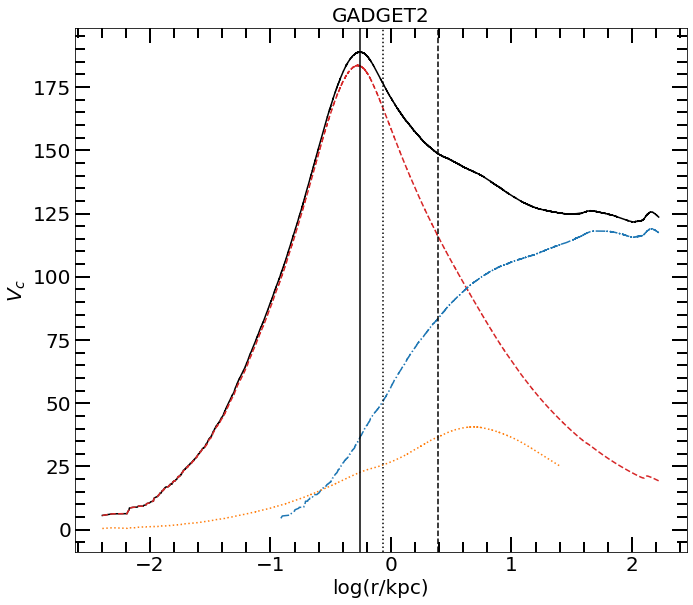

Md =  4.86462e+09 Rd =  3.24834


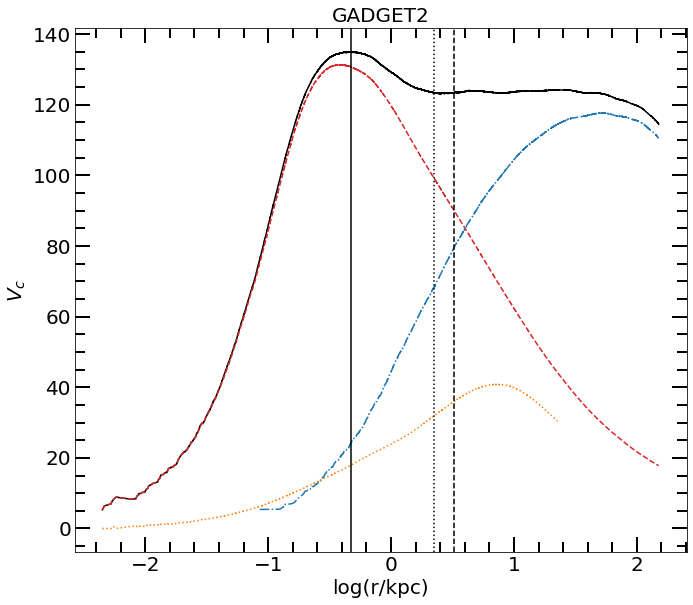

Md =  2.76201e+09 Rd =  3.42282


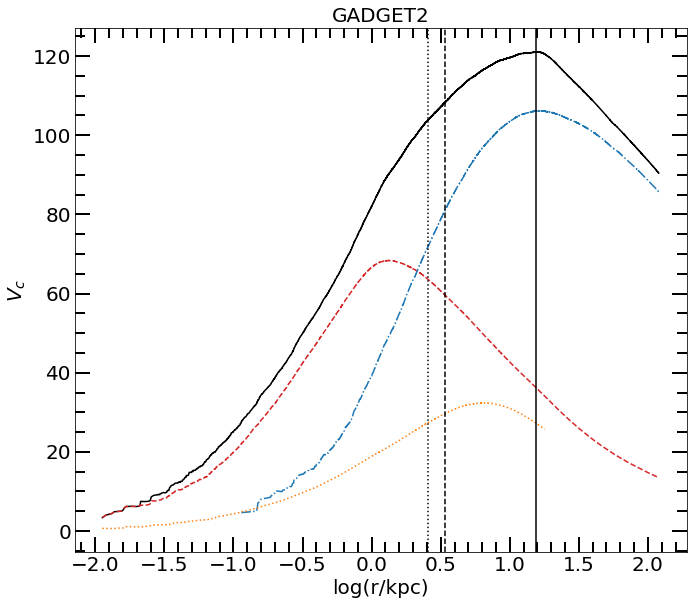

In [53]:
#Graficamos la veloc circular pero con la flecha de V200 y solo para los 3 halos mas grandes
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np

colors = ('r','b','g')

G = 4.299e-6
a0= 1.
vector2 = ('M31','MW','M33')
vector = (1,2,4)

path = '/home/ornela/SimCLUES/'

snap = h5py.File(path + 'Gasoline/outputs2/snap_1024.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'][()]
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'][()]
    time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'][()]
    h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'][()]
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'][()]

    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Masses'][()]
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'][()]

    pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'][()]
    mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'][()]

    pdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Coordinates'][()]
    mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'][()]

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0]) #*aexp
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] 
    v_y = vel[:,1] 
    v_z = vel[:,2]

#------------------------------------------------
    r200 = r200*aexp

#     print 'r200=', r200
    rgal=0.15*r200

    limit    = np.where(rstr<rgal)
    r_sort   = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    limit_str   = np.where(rstr<r200)
    rstr_sort   = np.sort(rstr[limit_str])
    rstr_indice = np.argsort(rstr[limit_str])

    limit_gas   = np.where(rgas<r200)
    rgas_sort   = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk   = np.where(rdrk<r200)
    rdrk_sort   = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])


    Mgal_str = np.cumsum((mstr[limit])[r_indice])

    Mc_str = np.cumsum((mstr[limit_str])[rstr_indice])

    Mc_gas = np.cumsum((mgas[limit_gas])[rgas_indice])

    Mc_drk = np.cumsum((mdrk[limit_drk])[rdrk_indice])

#------------------ calculamos r90, r50------------------------------------------
    M_gal = Mgal_str[-1]

    razon       = Mgal_str/M_gal
    cincuenta,    = np.where(razon < 0.50)

    r50 = r_sort[cincuenta][-1]

#--------------------------------------------------------------       
    rtot= np.concatenate([rstr, rgas, rdrk])
    mtot= np.concatenate([mstr, mgas, mdrk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

#--------------------------------------------------------------

    Vtot = np.sqrt((G*Mc_tot[1:])/rtot_sort[1:])
    Vstr = np.sqrt((G*Mc_str[1:])/rstr_sort[1:])
    Vgas = np.sqrt((G*Mc_gas[1:])/rgas_sort[1:])
    Vdrk = np.sqrt((G*Mc_drk[1:])/rdrk_sort[1:])

    rmax = rtot_sort[np.argmax(Vtot)]
#----------------------------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)

    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    #-------------------------------------------------------------------------------------
    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit, = np.where(rn < rgal )

    R = np.sqrt(xn[limit]**2+yn[limit]**2)
    Rsort = np.sort(R[1:])

    nbin = 25
    den, Rbin = density.surf_density(R[1:],mstr[limit][1:],nbin)


    cut, = np.where(Rbin > 3*aexp)
    pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

    Rd = -1./pol[0]

    Sigma_0 = np.exp(pol[1])

    Md = 2*np.pi * Sigma_0 * Rd**2 * (1 - np.exp(-Rsort/Rd) * (1 + Rsort/Rd))
    
    rsort =np.sort(rn[limit][1:])
    Vd = np.sqrt(G*Md/rsort)
#     nbin = 50
#     Vd, r_disk = vcirc.Vc_bin(rn[limit], Md_int, nbin)

    print ('Md = ', '%1.5e'%Md[-1], 'Rd = ', '%2.5f'%Rd)
    ##------------------------------------------------------------------------------------------------------

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))# sharey=True, sharex=True)
            #                        gridspec_kw = {'height_ratios':[3,1,3,1]})
    fig.subplots_adjust(bottom=0.06, left =0.12, right = 0.97, top = 0.97, wspace=0., hspace= 0)


    ax.plot(np.log10(rtot_sort[1:]), Vtot, '-', lw=1.5, color = 'k', label = 'Total')
    ax.plot(np.log10(rstr_sort[1:]), Vstr, '--',lw=1.5, color = 'tab:red', label = 'Stars')
    ax.plot(np.log10(rdrk_sort[1:]), Vdrk, '-.',lw=1.5, color = 'tab:blue', label =' Dark Matter')
    ax.plot(np.log10(rsort), Vd, ':',lw=1.5,   color = 'tab:orange', label =' M_disc')
    ax.axvline(x=np.log10(r50), lw=1.5, ls = ':', color='k')
    ax.axvline(x=np.log10(rmax),lw=1.5, color='k')
    ax.axvline(x=np.log10(Rd),lw=1.5, ls = '--', color='k')
    #     ax.set_ylim(1.5,2.3)
#     ax.set_xlim(0,30)
    ax.set_ylabel(r'$V_c$', fontsize=20)
    ax.set_xlabel(r'log(r/kpc)',fontsize=20)
    # ax[0].set_xticklabels([])
    ax.minorticks_on()
    ax.tick_params( labelsize=20)
    ax.tick_params('both', length=10, width=2,which='minor', direction='in', right=True,top=True)
    ax.tick_params('both', length=15, width=2,which='major', direction='in', right=True,top=True)
    ax.set_title('GADGET2', loc='center', fontsize=20)
    #     ax.legend(fontsize=18,frameon=False)
    plt.show()